In [1]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans
import networkx as nx
import math

Populating the interactive namespace from numpy and matplotlib


In [39]:
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = img // 4
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[x][y] += centers[classes[x][y]]
    result = np.clip(result, 0, 255)
    return result

In [40]:
def read_file( file, c):
        img_raw = PIL.Image.open(file)
        height, width = img_raw.size
        img_raw = img_raw.resize((round(height * c), round(width * c)), PIL.Image.ANTIALIAS)
        return np.array(img_raw)[:, :, :3].astype('int64')

In [41]:
def process_img(img_file, simplecut, mincut, centers, alpha, betta, c, show=False, show_penalty=False):
    img = read_file(img_file, c)

    centers = np.array(centers)
    
    classes = simplecut(img, centers)
    penalty = get_penalty(img, classes, centers, alpha, betta)
    clustered = apply_cut(img, classes, centers)
    
    min_classes = mincut(img, centers, alpha, betta)
    min_penalty = get_penalty(img, min_classes, centers, alpha, betta)
    min_clustered = apply_cut(img, min_classes, centers)
     
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(2, 2, 1)
        plt.imshow(img)

        fig.add_subplot(2, 2, 2)
        plt.imshow(clustered)
        
        fig.add_subplot(2, 2, 3)
        plt.imshow(min_clustered)
        plt.show()
    
    if show_penalty:
        print(img_file)
        print('Penalty with simple_cut equals %f' % penalty)
        print('Penalty with min-cut equals %f' % min_penalty)

    return penalty

In [42]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [43]:
def get_penalty(img, classes, centers, alpha, betta):
    assert len(centers) == 2
    a, b = 0, 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            a += dist1(img[x][y], centers[classes[x][y]])
            if x + 1 < img.shape[0]:
                if classes[x][y] != classes[x + 1][y]:
                    b += dist2(img[x][y], img[x + 1][y])
            if y + 1 < img.shape[1]:
                if classes[x][y] != classes[x][y + 1]:
                    b += dist2(img[x][y], img[x][y + 1])
            
    return alpha * a + betta * b

In [44]:
def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    n, m = img.shape[0], img.shape[1]
    for x in range(n):
        for y in range(m):
            if dist1(img[x][y], centers[0]) < dist2(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

Давайте напишим свой алгоритм min_cut, решающий задачу при помощи графа
Он будет учитывать не только пренадлежность, пикселя к класу, кторый выдал kmeans, но и будет учитывать штраф между соседнеми пикселями. Построим граф. Пиксели вершины. Добавим две вершины соответствующие 1 классу и 2 классу. Проведём из вершины -1 и -2  во все вершины-пиксели с штрафом.


In [30]:
def dist1(c1, c2):
    return math.sqrt(((c1 - c2) ** 2).sum())

def dist2(c1, c2):
    return 1.0 / (1.0 + dist1(c1, c2) / 255.0)

def node_id(i, j, n):
    return n * i + j

def id_node(x, n):
    i = x // n
    j = x % n
    return i, j

def min_cut(img, centers, alpha, betta):
    classes = np.zeros_like(img[:, :, 0])
    Graph = nx.DiGraph()
    n, m = img.shape[0], img.shape[1]
    
    for i in range(n):
        for j in range(m):
            if i + 1 < n:
                Graph.add_edge(node_id(i, j, m), node_id(i + 1, j, m), capacity = betta * dist2(img[i][j], img[i + 1][j]))
            if j + 1 < m:
                Graph.add_edge(node_id(i, j, m), node_id(i, j + 1, m), capacity = betta * dist2(img[i][j], img[i][j + 1]))
            if i - 1 >= 0:
                Graph.add_edge(node_id(i, j, m), node_id(i - 1, j, m), capacity = betta * dist2(img[i][j], img[i - 1][j]))
            if j - 1 >= 0:
                Graph.add_edge(node_id(i, j, m), node_id(i, j - 1, m), capacity = betta * dist2(img[i][j], img[i][j - 1]))
                
            Graph.add_edge(-1, node_id(i, j, m), capacity = alpha * dist1(img[i][j], centers[1]))
            Graph.add_edge(node_id(i, j, m), -2, capacity = alpha * dist1(img[i][j], centers[0]))
    
    mval, partition = nx.minimum_cut(Graph, -1, -2)
    
    for vertex in partition[0]:
        if vertex == -1:
            continue
        x, y = id_node(vertex, m)
        classes[x][y] = 0
    
    for vertex in partition[1]:
        if vertex == -2:
            continue
        x, y = id_node(vertex, m)
        classes[x][y] = 1
    
    return classes

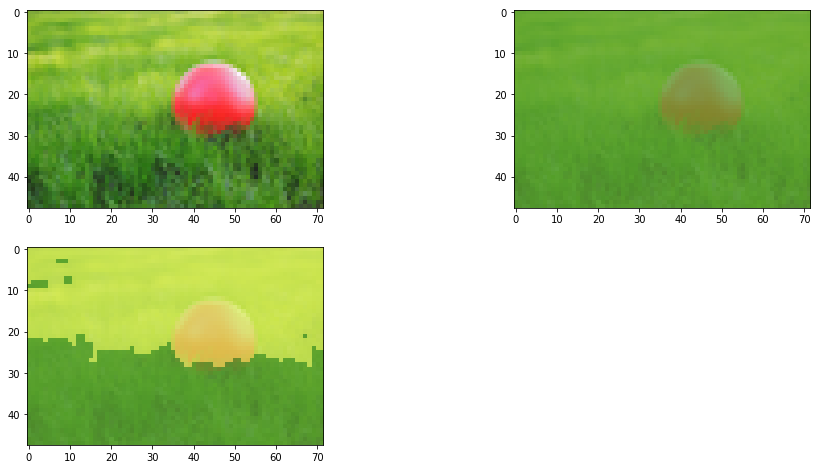

./imgs\ball.jpg
Penalty with simple_cut equals 1346683.085837
Penalty with min-cut equals 673326.207163


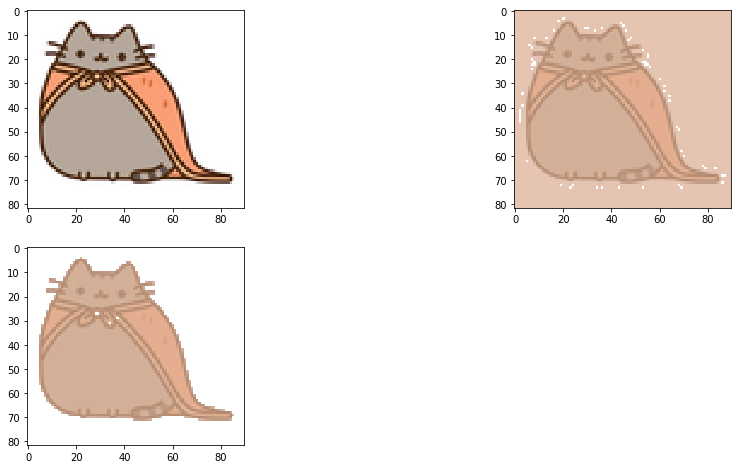

./imgs\cat.png
Penalty with simple_cut equals 5341048.074977
Penalty with min-cut equals 1397675.705175


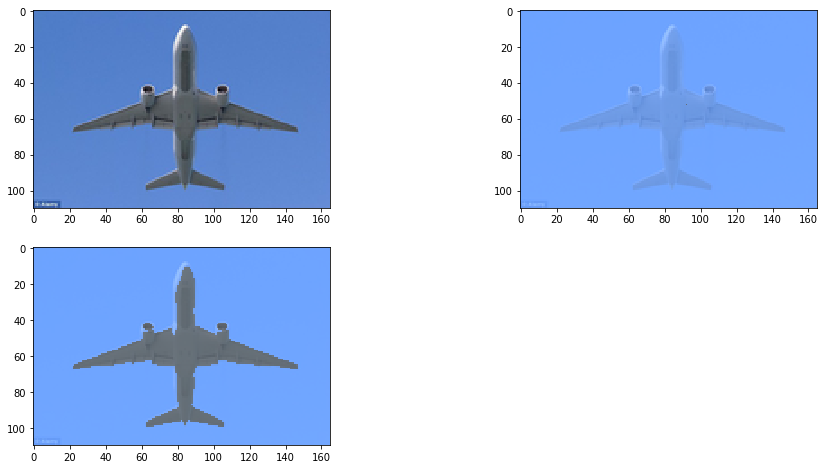

./imgs\plane.jpg
Penalty with simple_cut equals 2055446.965892
Penalty with min-cut equals 959054.561249


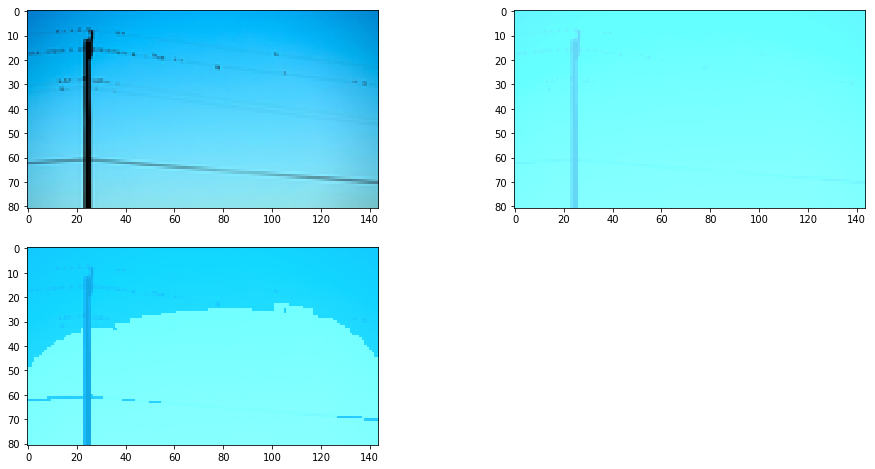

./imgs\sky.jpg
Penalty with simple_cut equals 3265120.205117
Penalty with min-cut equals 1872630.321119


In [49]:
alpha, betta = 5.0, 25.0

for img in glob('./imgs/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta,0.3, True, True)

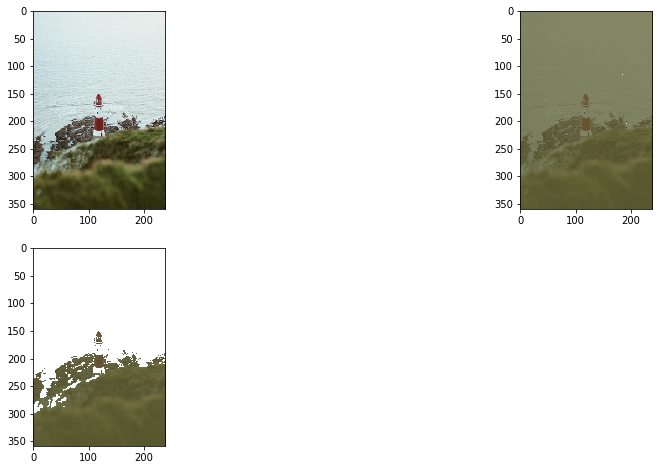

./imgs_multicolor\beacon.jpg
Penalty with simple_cut equals 75691769.244950
Penalty with min-cut equals 11834568.264329


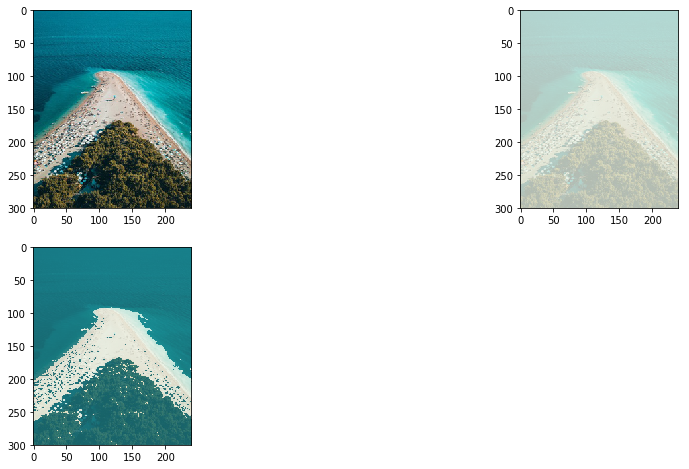

./imgs_multicolor\coast.jpg
Penalty with simple_cut equals 60447458.512732
Penalty with min-cut equals 22672276.973040


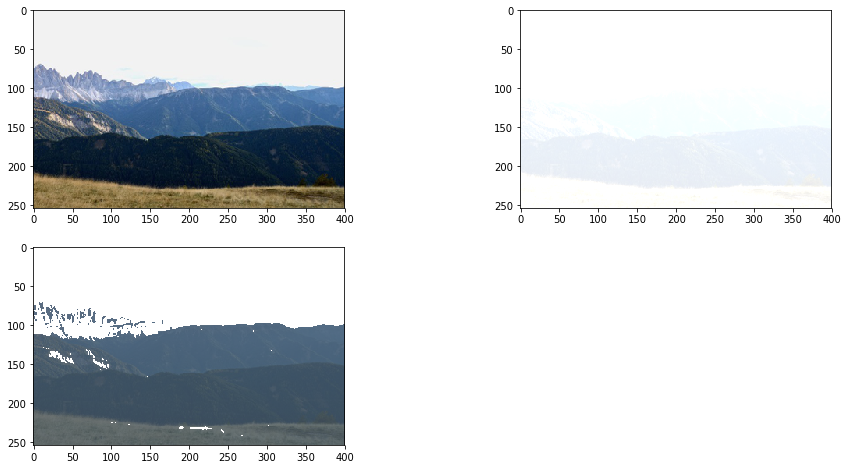

./imgs_multicolor\landscape.jpg
Penalty with simple_cut equals 89505377.789167
Penalty with min-cut equals 28470007.664949


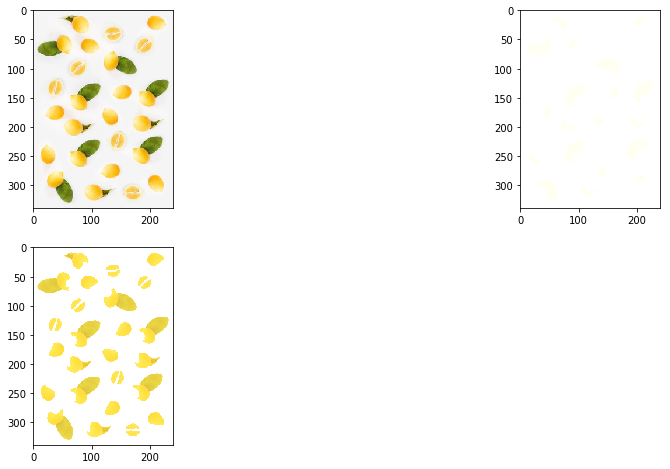

./imgs_multicolor\lemons.jpg
Penalty with simple_cut equals 21843051.205660
Penalty with min-cut equals 11404274.229171


In [50]:
for img in glob('./imgs_multicolor/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta,0.8, True, True)

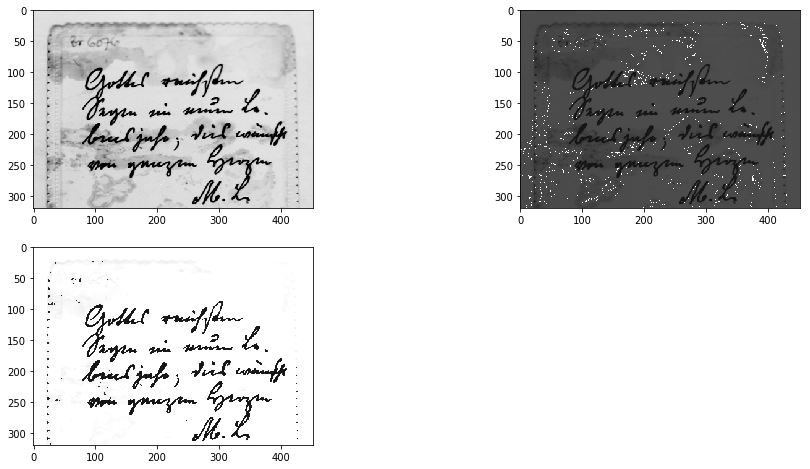

./DIPCO2016_dataset\1.bmp
Penalty with simple_cut equals 1043707557.384546
Penalty with min-cut equals 98097538.931851


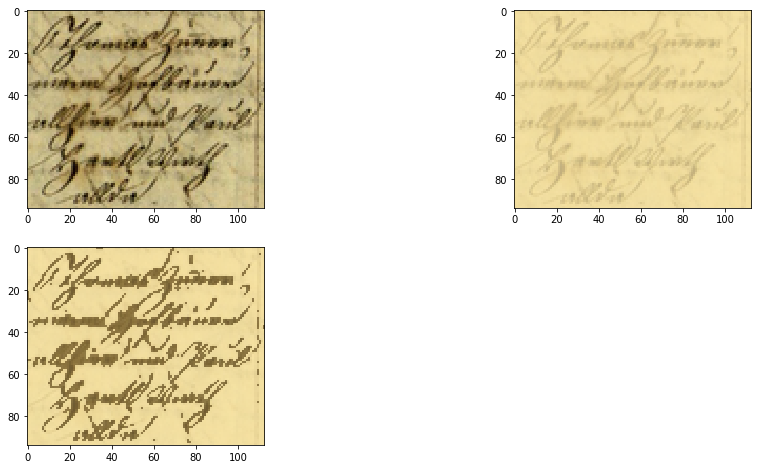

./DIPCO2016_dataset\10.bmp
Penalty with simple_cut equals 12397003.680526
Penalty with min-cut equals 6887793.982947


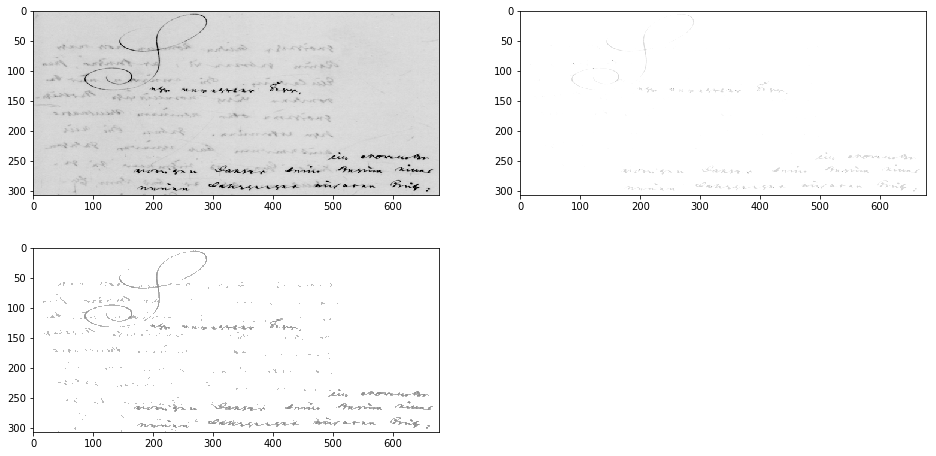

./DIPCO2016_dataset\2.bmp
Penalty with simple_cut equals 62981447.464767
Penalty with min-cut equals 48964002.249180


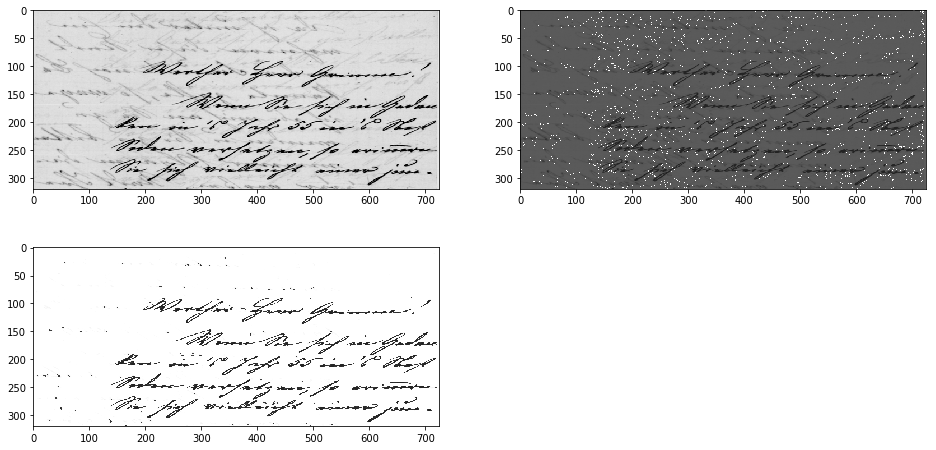

./DIPCO2016_dataset\3.bmp
Penalty with simple_cut equals 1601040969.109756
Penalty with min-cut equals 112168695.883183


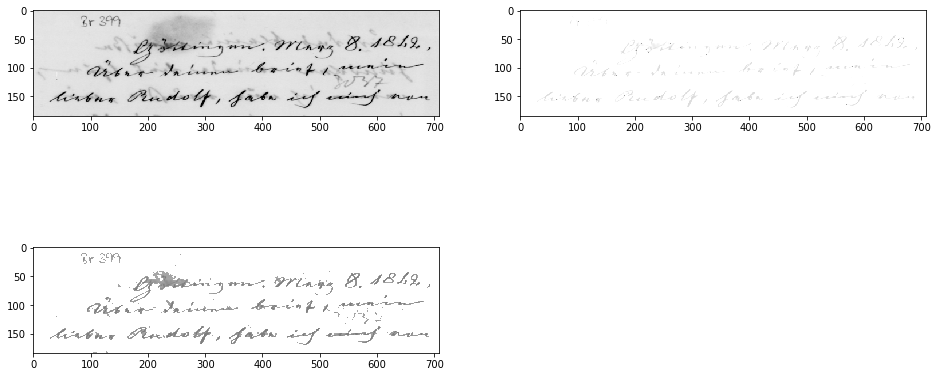

./DIPCO2016_dataset\4.bmp
Penalty with simple_cut equals 84059462.616915
Penalty with min-cut equals 55844528.186928


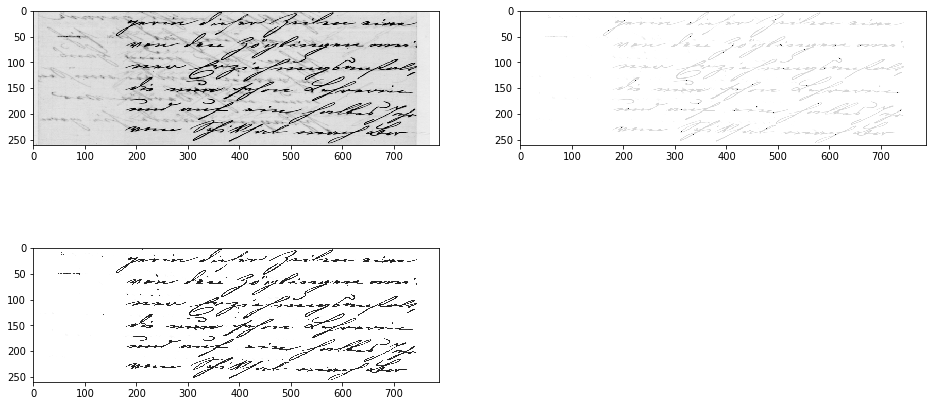

./DIPCO2016_dataset\5.bmp
Penalty with simple_cut equals 196270077.767642
Penalty with min-cut equals 112370847.572217


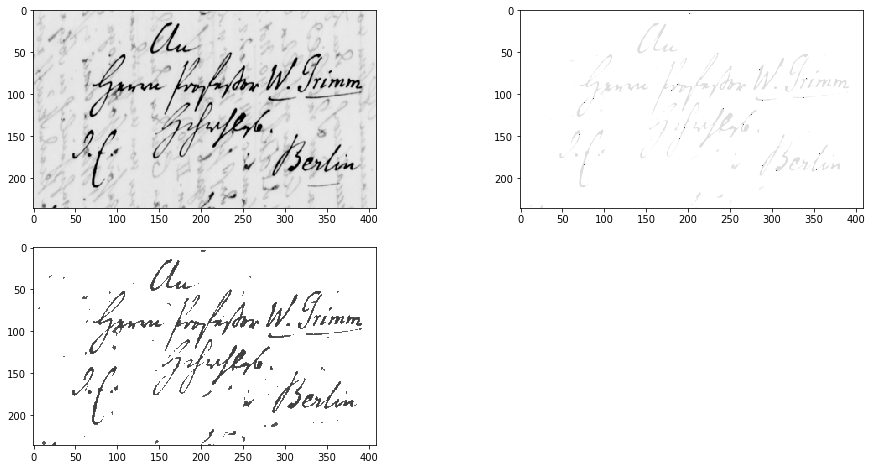

./DIPCO2016_dataset\6.bmp
Penalty with simple_cut equals 78900843.966062
Penalty with min-cut equals 49536424.498510


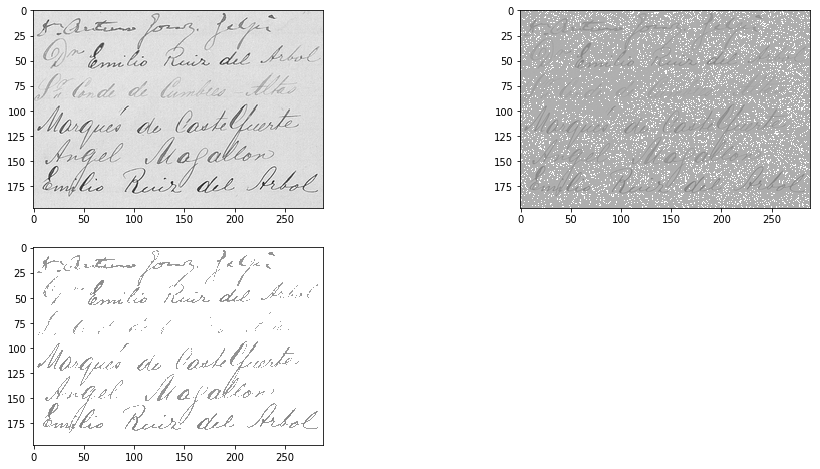

./DIPCO2016_dataset\7.bmp
Penalty with simple_cut equals 205220217.241101
Penalty with min-cut equals 15962048.932339


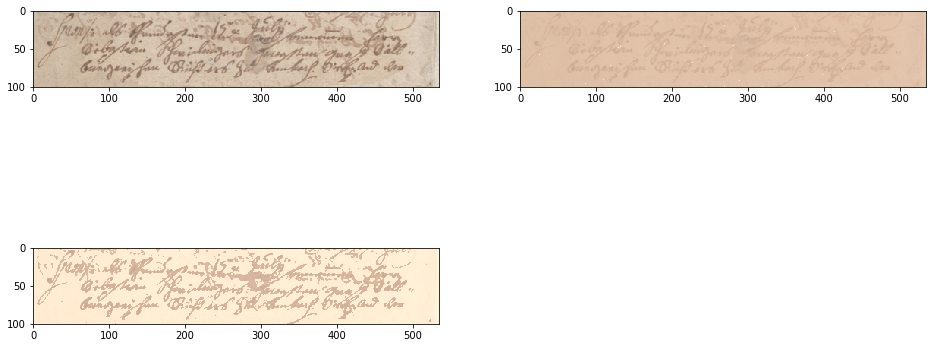

./DIPCO2016_dataset\8.bmp
Penalty with simple_cut equals 77812796.728025
Penalty with min-cut equals 19523976.213289


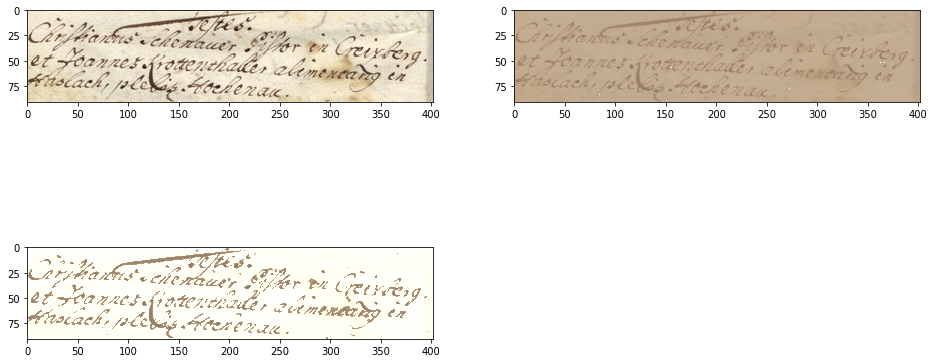

./DIPCO2016_dataset\9.bmp
Penalty with simple_cut equals 139669408.344618
Penalty with min-cut equals 22628367.654460


In [34]:
for img in glob('./DIPCO2016_dataset/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta,0.3, True, True)

Наш алгоритм работает лучше чем, simple_cut. Заметим также, что чем A < B, тем менее вероятны случайные выбросы . Края классов становятся более плавными. Классы становятся более однородными, без случайных пикселей в центре класса. Это следует из того, что если пикскль окружён пикселями другого цвета, то нам не выгодно добовлять его в противоположный класс, даже если по цвету он немного ближе к нему, мы за это заплатим большой штраф. Для алгоритма simple_cut в отличие от my_cut это не важно, алгоритм simple_cut никак не смотрит на соседние пиксели, он принемает решения только изходя из цвета пикселя. Заметим также что алгоритм my_cut сводится к алгоритму simple_cut, если B=0.